# Background Information and Write-up

## High Level Overview

This project can be split up into two main components: the digitial communications portion and the deep learning portion. On one hand, the digital communications side of the project involves generating symbols based off a given modulation scheme, adding noise to that symbol, and calculating the Log-Likelihood Ratio (LLR) of ecah bit. On the other hand, a neural network is created in order to attempt to predict these LLRs only given the noisy constellation. Note that all the digital communications functions are implemented using MATLAB and fed into Python using .csv files.


## Generating the Data and Digital Communications Background

### Generating data

To create a random symbol vector, I utilized the randi() function in MATLAB to genenerate a vector with values in the range [1,M] where M is the modulation order. Then, using a pre-defined constellation map, each entry of this vector is mapped to the correct constellation. After, complex AWGN noise is added and then we calculate the LLRs.

### Calculating LLRs

The Log-Likelihood Ratio of a bit $i$ is defined by the equation below where $b_i$ is the original bit sent and $r$ is the input to the reciever:

$$ LLR_{b_i} = \log{\left( \frac{p(b_i = 0 | r)}{p(b_i = 1 | r)} \right)}$$

Applying Baye's Rule to this expression, we arrive at:

$$
\begin{align} LLR_{b_i} &= \log{\left( \frac{\frac{p(r | b_i = 0)p(b_i = 0)}{p(r)}}{\frac{p(r | b_i = 1)p(b_i = 1)}{p(r)}} \right)} \\
&= \log{\left( \frac{p(r | b_i = 0)p(b_i = 0)}{p(r |b_i = 1)p(b_i=1)} \right)} \\
&= \log{\left( \frac{p(r | b_i = 0)}{p(r | x = 1)}\right)} + \log{\left(\frac{p(b_i=0)}{p(b_i=1)} \right)} \end{align} \\
$$

<br> <br>
If we assume our input bits are equally distributed (ie: $p(b_i=0) = p(b_i=1) = 0.5$), the second term vanishes. 

$$LLR_{b_i} = \log{\left( \frac{p(r | b_i = 0)}{p(r | x = 1)}\right)}$$

<br> <br>
Additionally, we assume our noise to be iid multi-dimensional Gaussian random variables with parameters $\mu = \textbf{0}$ and $\Sigma = (N_0/2) I_k$. Lastly, note that there may be several constellations that correspond to $b_i = 0$. Therefore, in order to obtain $p(r | b_i = 0)$, we apply the law of total prbability and sum over the subset of constellations which satisfy $b_i =0$, denoted below as $\mathcal{X_0}$ 


$$
p(r | b_i = 0) = \sum_{x \in \mathcal{X_0}}{\frac{1}{\sqrt{N_0 \pi }}\text{exp} \left( -\frac{1}{N_0} \left\| r - x \right\|^2 \right)}
$$

<br><br>
Bringing this all together, we obtain the final expression for the LLR of bit $i$:

$$ LLR_{b_i} = \log{\left( \frac{\sum_{x \in \mathcal{X_0}}{\text{exp} \left( -\frac{1}{N_0} \left\| r - x \right\|^2 \right)}}{\sum_{x \in \mathcal{X_1}}{\text{exp} \left( -\frac{1}{N_0} \left\| r - x \right\|^2 \right)}}\right)}
$$

<br><br>
For BSPK modulation with one dimensional noise, this simplifies to the following:

$$\begin{align} LLR_{b_i} &= \log{\left( \frac{{\text{exp} \left( -\frac{1}{N_0} \left( r - \sqrt{E_b} \right)^2 \right)}}{\text{exp} \left( -\frac{1}{N_0} \left( r + \sqrt{E_b} \right)^2 \right)}\right)} \\
&= 4 \left(\frac{E_b}{N_0} \right) r \end{align} $$

In the MATLAB code, I purposefuly created my constellation maps such that each successive entry corresponded to a constellation with a binary value one greater than the last. For instance, if constellation_map[1] corresponded to the binary value 00, constellation_map[2] corresponded to 01 and so on. By doing so, figuring out which constellations have a certain bit equal to 0 or 1 becomes much easier. For example, if we looped through every constellation, we would switch whether we are looking at bit 0 or 1 with every iteration. For the second LSB, we would switch whether we are looking at bit 0 or 1 every 2 iterations. For the third LSB, we would switch every 4 iterations and so on.

# Mount Google Drive to access files

In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
os.chdir('/content/gdrive/My Drive/LLR_NN')
!ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
data_files_multiple_snr  data_files_single_snr


In [0]:
%%capture
!pip install tensorflow-gpu==2.1.0

## Import Required Libraries

In [0]:
import numpy as np
import scipy.io as sio
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, MaxPooling1D
from tensorflow.keras.layers import Activation,Conv2D, Flatten, Permute, Cropping2D
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Reshape
from tensorflow.keras.layers import Conv1D, GRU
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import matplotlib.pyplot as plt

# Load the Data

In [4]:
MODULATION = "16_QAM"
SNR = "2"
SNR_RANGE_MIN = "-5"
SNR_RANGE_MAX = "20"

# Load the training data
X_train_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_X_train_snr_" + SNR + ".csv", delimiter=',')
y_train_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_y_train_snr_" + SNR + ".csv", delimiter=',')
X_train_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_X_train_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
y_train_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_y_train_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')

# Load validation data
X_valid_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_X_valid_snr_" + SNR + ".csv", delimiter=',')
y_valid_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_y_valid_snr_" + SNR + ".csv", delimiter=',')
X_valid_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_X_valid_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
y_valid_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_y_valid_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')

# Load the test data
X_test_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_X_test_snr_" + SNR + ".csv", delimiter=',')
y_test_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_y_test_snr_" + SNR + ".csv", delimiter=',')
X_test_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_X_test_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
y_test_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_y_test_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')

# Reshape the data
X_train_single_SNR = X_train_single_SNR.T
X_valid_single_SNR = X_valid_single_SNR.T
X_test_single_SNR = X_test_single_SNR.T
X_train_multiple_SNR = X_train_multiple_SNR.T
X_valid_multiple_SNR = X_valid_multiple_SNR.T
X_test_multiple_SNR = X_test_multiple_SNR.T

y_train_single_SNR = y_train_single_SNR.T
y_valid_single_SNR = y_valid_single_SNR.T
y_test_single_SNR = y_test_single_SNR.T
y_train_multiple_SNR = y_train_multiple_SNR.T
y_valid_multiple_SNR = y_valid_multiple_SNR.T
y_test_multiple_SNR = y_test_multiple_SNR.T

# Special case for M=2 since the data imported was only 1D
if(len(y_train_single_SNR.shape) == 1):
  y_train_single_SNR = y_train_single_SNR.reshape([-1,1])
  y_valid_single_SNR = y_valid_single_SNR.reshape([-1,1])
  y_test_single_SNR = y_test_single_SNR.reshape([-1,1])
  y_train_multiple_SNR = y_train_multiple_SNR.reshape([-1,1])
  y_valid_multiple_SNR = y_valid_multiple_SNR.reshape([-1,1])
  y_test_multiple_SNR = y_test_multiple_SNR.reshape([-1,1])

print("Training data single SNR shape: \t\t", X_train_single_SNR.shape)
print("Validation data single SNR shape: \t\t",X_valid_single_SNR.shape)
print("Test data single SNR shape: \t\t\t" ,X_test_single_SNR.shape)

print()
print("Training label single SNR shape: \t\t", y_train_single_SNR.shape)
print("Validation label single SNR shape: \t\t", y_valid_single_SNR.shape)
print("Test label single SNR shape: \t\t\t", y_test_single_SNR.shape)

print()
print("Training data multiple SNR shape: \t\t", X_train_multiple_SNR.shape)
print("Validation data multiple SNR shape: \t\t",X_valid_multiple_SNR.shape)
print("Test data multiple SNR shape: \t\t\t" ,X_test_multiple_SNR.shape)

print()
print("Training label multiple SNR shape: \t\t", y_train_multiple_SNR.shape)
print("Validation label multiple SNR shape: \t\t", y_valid_multiple_SNR.shape)
print("Test label multiple SNR shape: \t\t\t", y_test_multiple_SNR.shape)

Training data single SNR shape: 		 (10000, 2)
Validation data single SNR shape: 		 (1500, 2)
Test data single SNR shape: 			 (3000, 2)

Training label single SNR shape: 		 (10000, 4)
Validation label single SNR shape: 		 (1500, 4)
Test label single SNR shape: 			 (3000, 4)

Training data multiple SNR shape: 		 (13000, 2)
Validation data multiple SNR shape: 		 (3900, 2)
Test data multiple SNR shape: 			 (7800, 2)

Training label multiple SNR shape: 		 (13000, 4)
Validation label multiple SNR shape: 		 (3900, 4)
Test label multiple SNR shape: 			 (7800, 4)


# Construct Fully Connected Neural Net trained on a single SNR (2 dB)


## Define the model. Note that we have multiple outputs corresponding to each bit LLR.

In [5]:
model_input = Input(shape=(X_train_single_SNR.shape[1]), name='model_input')
num_outputs = y_train_single_SNR.shape[1]
num_layers = 7

# Create Dense Layers; these layers are shared between ALL outputs
x = Dense(256, activation='relu')(model_input)
for i in range(num_layers, 1, -1):
  x = Dense(max(num_outputs*2, 2**i), activation="relu")(x)

# Create more Dense layers that are unique to each output
output_vec = [None]*num_outputs
for i in range(num_outputs):
  out_layer_name = "LLR_bit_" + str(i+1)
  bit_layer = Dense(4, activation  = 'relu', name = "bit_layer_" + str(i + 1))(x)
  output_vec[i] = Dense(1, activation = "linear", name = out_layer_name)(bit_layer)

model = Model(inputs = model_input, outputs = output_vec)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          768         model_input[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Train the model on single SNR

In [0]:
# Experimented with model parameters:
# Can choose loss function, metrics, optimizer parameters
model.compile(loss='logcosh',
              optimizer = optimizers.Nadam(),
              metrics = ['mean_squared_error'])

# Since we have one output per bit, store the results of each its own list
y_train_flattened = [None] * num_outputs
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

# Load the list with the LLRs of each bit
for i in range(num_outputs):
  y_train_flattened[i] = y_train_single_SNR[:,i]
  y_valid_flattened[i] = y_valid_single_SNR[:,i]
  y_test_flattened[i] = y_test_single_SNR[:,i]

# Train the model finally
history = model.fit(X_train_single_SNR, y_train_flattened, validation_data=(X_valid_single_SNR, y_valid_flattened), batch_size=50, epochs=100, verbose = 0)

## Evaluate the Model on the same SNR

In [7]:
# Test model on the validation and test set and report results
score_val = model.evaluate(X_valid_single_SNR, y_valid_flattened, batch_size = 100, verbose=0)
score_test = model.evaluate(X_test_single_SNR, y_test_flattened, batch_size = 100, verbose=0)

print("Evaluate model on the validation set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_val[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_val[i+1], "\t, ", score_val[i+3])

print("\n\nEvaluate model on the test set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+1], "\t, ", score_test[i+3])

Evaluate model on the validation set:
---------------------------------------------------
Total Loss: 			 0.0048150248980770504
Bit 0 [Loss, MSE] is: 		 0.000109377506 	,  0.00016963406
Bit 1 [Loss, MSE] is: 		 0.0012077533 	,  0.0033282598
Bit 2 [Loss, MSE] is: 		 0.00016963406 	,  0.00021879554
Bit 3 [Loss, MSE] is: 		 0.0033282598 	,  0.0024173197


Evaluate model on the test set:
---------------------------------------------------
Total Loss: 			 0.007004390152481695
Bit 0 [Loss, MSE] is: 		 0.0001318066 	,  0.00018662102
Bit 1 [Loss, MSE] is: 		 0.0012382243 	,  0.005447739
Bit 2 [Loss, MSE] is: 		 0.00018662102 	,  0.00026375506
Bit 3 [Loss, MSE] is: 		 0.005447739 	,  0.0024784103


### Plot the LLRs acquired from the neural net vs actual LLRs`

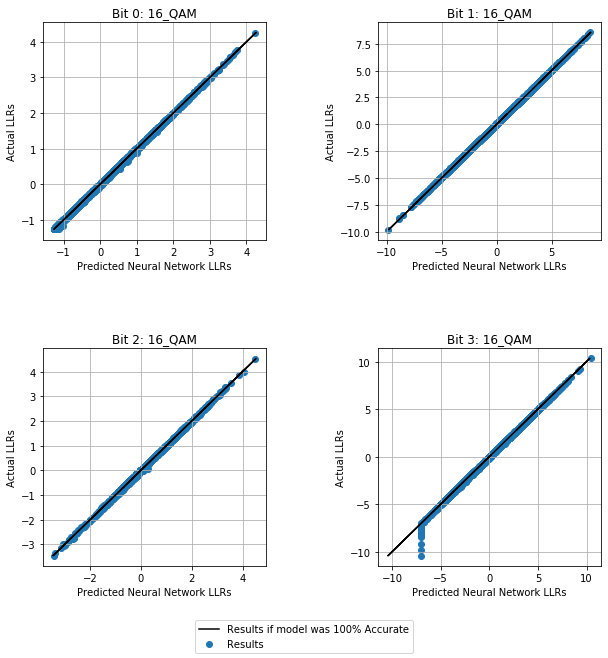

In [8]:
y_pred = [None]*num_outputs
y_pred = model.predict(X_test_single_SNR)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test_single_SNR[:,i].reshape([-1,1]))
  plt.plot(y_test_single_SNR[:,i].reshape([-1,1]), y_test_single_SNR[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.5)
f.legend(('Results if model was 100% Accurate', 'Results', ), loc = 'lower center')
plt.show()

## Evaluate the Model on various SNR

In [9]:
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_test_flattened[i] = y_test_multiple_SNR[:,i]

# Test model on the validation and test set and report results
score_test = model.evaluate(X_test_multiple_SNR, y_test_flattened, batch_size = 100, verbose=0)

print("\n\nEvaluate model on multiple SNR:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+1], "\t, ", score_test[i+3])



Evaluate model on multiple SNR:
---------------------------------------------------
Total Loss: 			 3.7299320820050363
Bit 0 [Loss, MSE] is: 		 0.5031522 	,  0.3027981
Bit 1 [Loss, MSE] is: 		 1.5069672 	,  1.4170145
Bit 2 [Loss, MSE] is: 		 0.3027981 	,  1.5178679
Bit 3 [Loss, MSE] is: 		 1.4170145 	,  7.1944


### Plot the LLRs acquired from the neural net vs actual LLRs

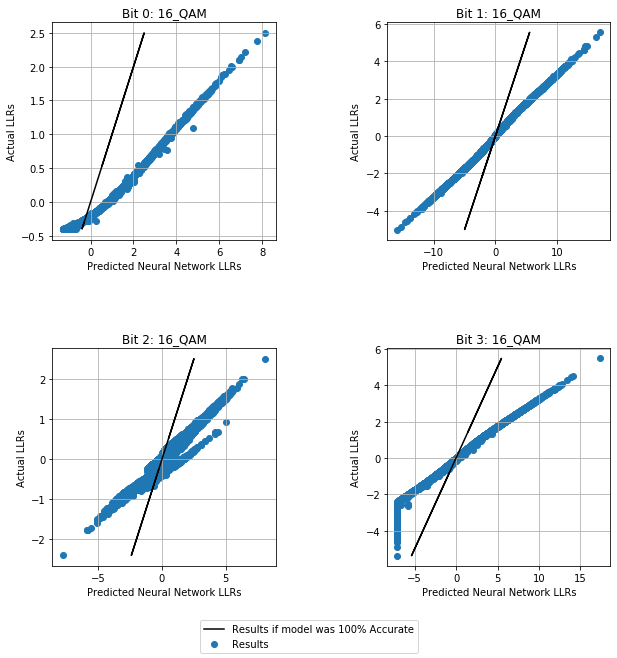

In [10]:
y_pred = [None]*num_outputs
y_pred = model.predict(X_test_multiple_SNR)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test_multiple_SNR[:,i].reshape([-1,1]))
  plt.plot(y_test_multiple_SNR[:,i].reshape([-1,1]), y_test_multiple_SNR[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

f.legend(('Results if model was 100% Accurate', 'Results', ), loc = 'lower center')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

# Construct Fully Connected Neural Net trained on multiple SNR (-5 dB to 20 dB)

## Define the model. Note that we have multiple outputs corresponding to each bit LLR.

In [11]:
model_input = Input(shape=(X_train_multiple_SNR.shape[1]), name='model_input')
num_outputs = y_train_multiple_SNR.shape[1]
num_layers = 6

x = Dense(128, activation='relu')(model_input)
for i in range(num_layers, 1, -1):
  x = Dense(max(num_outputs*2, 2**i), activation="relu")(x)

output_vec = [None]*num_outputs
for i in range(num_outputs):
  out_layer_name = "LLR_bit_" + str(i+1)
  x = Dropout(0.5)(x)
  bit_layer = Dense(4, activation  = 'relu', name = "bit_layer_" + str(i + 1))(x)
  output_vec[i] = Dense(1, activation = "linear", name = out_layer_name)(bit_layer)

model_multiple_snr = Model(inputs = model_input, outputs = output_vec)
model_multiple_snr.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          384         model_input[0][0]                
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           8256        dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 32)           2080        dense_8[0][0]                    
____________________________________________________________________________________________

## Train the model on multiple SNR

In [0]:
# Experimented with model parameters:
# Can choose loss function, metrics, optimizer parameters
model_multiple_snr.compile(loss='logcosh',
              optimizer = optimizers.Nadam(),
              metrics = ['mean_squared_error'])

# Since we have one output per bit, store the results of each its own list
y_train_flattened = [None] * num_outputs
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_train_flattened[i] = y_train_multiple_SNR[:,i]
  y_valid_flattened[i] = y_valid_multiple_SNR[:,i]
  y_test_flattened[i] = y_test_multiple_SNR[:,i]

history = model_multiple_snr.fit(X_train_multiple_SNR, y_train_flattened, validation_data=(X_valid_multiple_SNR, y_valid_flattened), batch_size=50, epochs=100, verbose = 0)

## Evaluate the model on a various SNR

In [13]:
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_valid_flattened[i] = y_valid_multiple_SNR[:,i]
  y_test_flattened[i] = y_test_multiple_SNR[:,i]

# Test model on the validation and test set and report results
score_valid = model_multiple_snr.evaluate(X_valid_multiple_SNR, y_valid_flattened, batch_size = 100, verbose=0)
score_test = model_multiple_snr.evaluate(X_test_multiple_SNR, y_test_flattened, batch_size = 100, verbose=0)

print("\n\nEvaluate model on the validation set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_valid[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_valid[i+1], "\t, ", score_valid[i+3])

print("\n\nEvaluate model on the test set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+1], "\t, ", score_test[i+3])



Evaluate model on the validation set:
---------------------------------------------------
Total Loss: 			 1.2372687046344464
Bit 0 [Loss, MSE] is: 		 0.053099215 	,  0.06806343
Bit 1 [Loss, MSE] is: 		 0.5779014 	,  0.5382046
Bit 2 [Loss, MSE] is: 		 0.06806343 	,  0.11603825
Bit 3 [Loss, MSE] is: 		 0.5382046 	,  1.6032349


Evaluate model on the test set:
---------------------------------------------------
Total Loss: 			 1.4479139569478157
Bit 0 [Loss, MSE] is: 		 0.080995284 	,  0.08088382
Bit 1 [Loss, MSE] is: 		 0.6432792 	,  0.6427557
Bit 2 [Loss, MSE] is: 		 0.08088382 	,  0.18363054
Bit 3 [Loss, MSE] is: 		 0.6427557 	,  1.9103028


### Plot the LLRs acquired from the neural net vs actual LLRs`

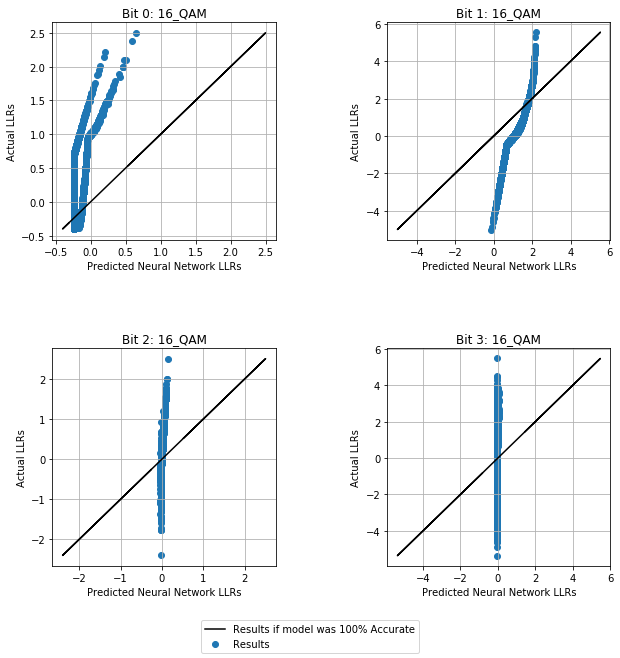

In [14]:
y_pred = [None]*num_outputs
y_pred = model_multiple_snr.predict(X_test_multiple_SNR)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test_multiple_SNR[:,i].reshape([-1,1]))
  plt.plot(y_test_multiple_SNR[:,i].reshape([-1,1]), y_test_multiple_SNR[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

f.legend(('Results if model was 100% Accurate', 'Results', ), loc = 'lower center')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

This output indicates that the SNR range is too varied to make any meaningful training. The network, while trying to minimize the loss, clearly found that predicting an LLR of 0, regardless of the input, was optimal. This indicates that, if we were to use this approach, we should train over a much narrower range of SNRs. 